In [1]:
# Preliminary data notebook for
# NIH: Imaging Guided Intervention Surgery Study Section

# Exploratory aim: evaluate presurgical scans between STN and GPi targets
#   Given retrospective GPi acquisitions?
#   Search for radiomic differentiators for STN versus GPi selection in presurgical scans

In [2]:
# Import libraries
from radiomics import featureextractor
from time import time
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy.matlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
import nibabel as nib
from sklearn.preprocessing import StandardScaler
import SimpleITK as sitk
import six
import trimesh
import numpy as np
from numpy import linalg
import os
import pywt
import pickle
import sys
from scipy.stats import wilcoxon
from scipy.stats import linregress
import pandas as pd
import nrrd
from util import plot_correlation_heatmap
import logging

%matplotlib widget

In [3]:
plt.style.use('dark_background')
plt.rcParams["figure.figsize"] = (15,5)
def remove_keymap_conflicts(new_keys_set):
    for prop in plt.rcParams:
        if prop.startswith('keymap.'):
            keys = plt.rcParams[prop]
            remove_list = set(keys) & new_keys_set
            for key in remove_list:
                keys.remove(key)

def multi_slice_viewer(volume):
    remove_keymap_conflicts({'j', 'k'})
    fig, ax = plt.subplots()
    ax.volume = volume
    ax.index = volume.shape[0]//2
    ax.imshow(volume[ax.index])
    fig.canvas.mpl_connect('key_press_event', process_key)

def process_key(event):
    fig = event.canvas.figure
    ax = fig.axes[0]
    if event.key == 'j':
        previous_slice(ax)
    elif event.key == 'k':
        next_slice(ax)
    fig.canvas.draw()
    

def previous_slice(ax):
    volume = ax.volume
    ax.index = (ax.index-1) % volume.shape[0] 
    ax.images[0].set_array(volume[ax.index])

def next_slice(ax):
    volume = ax.volume
    ax.index = (ax.index+1) % volume.shape[0]
    ax.images[0].set_array(volume[ax.index])

In [4]:
true_dir = '/media/mts_dbs/mclaro/nii/gt/'
laro_dir = '/media/mts_dbs/mclaro/nii/lr/'
vd_dir = '/media/mts_dbs/mclaro/nii/vd/'
seg_dir = '/media/mts_dbs/mclaro/nii/seg/'
true_niis = sorted(os.listdir(true_dir))
laro_niis = sorted(os.listdir(laro_dir))
vd_niis = sorted(os.listdir(vd_dir))
seg_niis = sorted(os.listdir(seg_dir))


In [5]:
# Set window level
level = 0
window = 0.6
m1=level-window/2
m2=level+window/2
visualize = 0
suf = 'us'
# Load data
segs = []
laros = []
vds = []
gts = []
voxel_sizes = []
trackers = []
dir = '/media/mts_dbs/mclaro/nii/'
files = os.listdir(dir)
case_ids = [9,10,11,12,13]
n_cases = len(case_ids)
for j in np.arange(n_cases):
        seg = nib.load(seg_dir+seg_niis[int(j)])
        laro = nib.load(laro_dir+laro_niis[int(j)])
        gt = nib.load(true_dir+true_niis[int(j)])
        vd = nib.load(vd_dir+vd_niis[int(j)])
        gts.append(np.asarray(gt.get_fdata()))
        laros.append(np.asarray(laro.get_fdata()))
        vds.append(np.asarray(vd.get_fdata()))
        segs.append(np.asarray(seg.get_fdata()))
        voxel_size = [0.5,0.5,0.5]
        laros_wl = np.asarray(laros)
        vds_wl = np.asarray(vds)
        segs_wl = np.asarray(segs)/10
        segs_wl[segs_wl>0.4] = 0
if visualize == 1:
        laros_wl[laros_wl < m1] = m1
        laros_wl[laros_wl > m2] = m2
        vds_wl[vds_wl < m1] = m1
        vds_wl[vds_wl > m2] = m2
        multi_slice_viewer(np.vstack(laros_wl+segs_wl).T)
        multi_slice_viewer(np.vstack(vds_wl+segs_wl).T)
        


In [6]:
# Only extract ROI if it is present in all cases
seg_labels_all = segs[0]
for i in range(n_cases-1):
    seg_labels = np.intersect1d(segs[i],segs[i+1])
    seg_labels_all = np.intersect1d(seg_labels_all,seg_labels)

In [7]:
# Generate feature structure Phi from all ROIs and all cases
extractor = featureextractor.RadiomicsFeatureExtractor()
extractor.enableAllFeatures()
extractor.enableAllImageTypes()
extractor.enableFeatureClassByName('shape2D',enabled = False)

In [8]:
logger = logging.getLogger("radiomics")
logger.setLevel(logging.ERROR)

Phi_gt = []
Phi_vd = []
Phi_lr = []
seg_labels = []
reextract = 1
x_row_gt = []
x_row_vd = []
x_row_lr = []
keylib = []
roilib = []
loop_count = 1
n_rois = seg_labels_all[seg_labels_all>0].__len__()
roi_names = []
roi_txt = pd.read_csv("/data/Ali/atlas/mcgill_pd_atlas/PD25-subcortical-labels.csv")
roi_df = roi_txt.astype(str)
if reextract == 1:
    for i in range(n_cases):
        seg_sitk = sitk.GetImageFromArray(segs[i])
        seg_sitk.SetSpacing(voxel_size)
        qsm_sitk_gt = sitk.GetImageFromArray(gts[i])
        qsm_sitk_gt.SetSpacing(voxel_size)
        qsm_sitk_vd = sitk.GetImageFromArray(vds[i])
        qsm_sitk_vd.SetSpacing(voxel_size)
        qsm_sitk_lr = sitk.GetImageFromArray(laros[i])
        qsm_sitk_lr.SetSpacing(voxel_size)
        for j in seg_labels_all:
            if j>0:
                featureVector_gt = extractor.execute(qsm_sitk_gt,seg_sitk,label=int(j));
                Phi_gt.append(featureVector_gt)
                featureVector_vd = extractor.execute(qsm_sitk_vd,seg_sitk,label=int(j));
                Phi_vd.append(featureVector_vd)
                featureVector_lr = extractor.execute(qsm_sitk_lr,seg_sitk,label=int(j));
                Phi_lr.append(featureVector_lr)
                for key, value in six.iteritems(featureVector_gt):
                    if 'diagnostic' in key:
                        next
                    else:
                        x_row_gt.append(featureVector_gt[key])
                        x_row_vd.append(featureVector_vd[key])
                        x_row_lr.append(featureVector_lr[key])
                        keylib.append(key)
                        roilib.append(j)
                        mask = np.row_stack([roi_df[row].str.contains(str(int(roilib[-1])), na = False) for row in roi_df])
                        roi_names.append(np.asarray(roi_df.iloc[mask.any(axis=0),1])[0])
                        loop_count = loop_count+1
    
    X0_gt = np.array(x_row_gt)
    X0_vd = np.array(x_row_vd)
    X0_lr = np.array(x_row_lr)
    np.save('./npy/X0_gt_rois.npy',X0_gt)
    np.save('./npy/X0_vd_rois.npy',X0_vd)
    np.save('./npy/X0_lr_rois.npy',X0_lr)
    K = np.asarray(keylib)
    R = np.asarray(roi_names)
    np.save('./npy/K.npy',K)
    np.save('./npy/R.npy',R)

    print('Saving ground truth feature vector')
    with open('./phi/Phi_mcl_gt_roi', 'wb') as fp:  
        pickle.dump(Phi_gt, fp)

    print('Saving variable density feature vector')
    with open('./phi/Phi_mcl_vd_roi', 'wb') as fp:  
        pickle.dump(Phi_vd, fp)

    print('Saving LARO feature vector')
    with open('./phi/Phi_mcl_lr_roi', 'wb') as fp:  
        pickle.dump(Phi_lr, fp)
else:
    X0_gt = np.load('./npy/X0_gt_rois.npy')
    X0_vd = np.load('./npy/X0_vd_rois.npy')
    X0_lr = np.load('./npy/X0_lr_rois.npy')
    K = np.load('./npy/K.npy')
    R = np.load('./npy/R.npy')
    

Saving ground truth feature vector
Saving variable density feature vector
Saving LARO feature vector


In [9]:
n_features = loop_count/n_rois/n_cases

In [10]:
with open('./phi/Phi_mcl_gt_roi', "rb") as fp:  
    Phi_gt = pickle.load(fp)
    
with open('./phi/Phi_mcl_vd_roi', "rb") as fp:  
    Phi_vd = pickle.load(fp)

with open('./phi/Phi_mcl_lr_roi', "rb") as fp:  
    Phi_lr = pickle.load(fp)

In [11]:
n_roisc = Phi_gt.__len__()/n_cases
L = int(len(X0_gt)/n_cases)
n_features = int(L/n_rois)

In [12]:
X0_gts = X0_gt.reshape((n_cases,n_rois,n_features)).transpose((0,2,1))
X0_vds = X0_vd.reshape((n_cases,n_rois,n_features)).transpose((0,2,1))
X0_lrs = X0_lr.reshape((n_cases,n_rois,n_features)).transpose((0,2,1))
K_rs = K.reshape((n_cases,n_rois,n_features)).transpose((0,2,1))
R_rs = R.reshape((n_cases,n_rois,n_features)).transpose((0,2,1))

In [13]:
Mc_vds = np.zeros((X0_gts.shape[1],X0_gts.shape[2]))
Mi_vds = np.zeros((X0_gts.shape[1],X0_gts.shape[2]))
Mc_lrs = np.zeros((X0_gts.shape[1],X0_gts.shape[2]))
Mi_lrs = np.zeros((X0_gts.shape[1],X0_gts.shape[2]))
Kc = np.empty((X0_gts.shape[1],X0_gts.shape[2]),dtype=object)

In [14]:
def ccc(X01,X02):
    sigma1 = np.std(X01,axis = 0)
    sigma2 = np.std(X02,axis = 0)
    mu1 = np.mean(X01,axis = 0)
    mu2 = np.mean(X02,axis = 0)
    cov = np.mean((X01-mu1)*(X02-mu2),axis = 0)
    rho = cov/(sigma1*sigma2)
    rhoc = (2*rho*sigma1*sigma2)/(sigma1**2+sigma2**2+(mu1-mu2)**2)
    return rhoc

In [15]:
def icc(df):
    m = df.shape[0]
    k = df.shape[1]
    mu = np.nanmean(df)
    mu_j = df.mean(axis = 0)
    mu_i = df.mean(axis = 1)
    sT = (k/(m-1))*np.sum((mu-mu_i)**2)
    T = df
    sE = np.sum(np.sum((T-np.matlib.repmat(mu_i,k,1).T-np.matlib.repmat(mu_j,m,1)+mu)**2))/((m-1)*(k-1))
    rho = (sT-sE)/(sT+(k-1)*sE)
    return rho

In [16]:
for i in np.arange(X0_gts.shape[1]):
    for j in np.arange(X0_gts.shape[2]):
        Mc_vds[i,j] = ccc(X0_gts[:,i,j],X0_vds[:,i,j])
        Mc_lrs[i,j] = ccc(X0_gts[:,i,j],X0_lrs[:,i,j])
        Kc[i,j] = K_rs[1,i,j]

/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


In [17]:
# Loop over features and ROIs
for i in np.arange(X0_gts.shape[1]):
    for j in np.arange(X0_gts.shape[2]):
        # Compute over all cases at each feature i and ROI j
        dataset_vds = np.vstack((X0_gts[:,i,j],X0_vds[:,i,j]))
        dataset_lrs = np.vstack((X0_gts[:,i,j],X0_lrs[:,i,j]))
        Mi_vds[i,j] = icc(dataset_vds.T)
        Mi_lrs[i,j] = icc(dataset_lrs.T)

/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


In [18]:
rho_vds = Mc_vds*Mi_vds
rho_lrs = Mc_lrs*Mi_lrs
Mc_vds = Mc_vds[~np.isnan(rho_vds+rho_lrs).any(axis = 1),:]
Mi_vds = Mi_vds[~np.isnan(rho_vds+rho_lrs).any(axis = 1),:]
Mc_lrs = Mc_lrs[~np.isnan(rho_vds+rho_lrs).any(axis = 1),:]
Mi_lrs = Mi_lrs[~np.isnan(rho_vds+rho_lrs).any(axis = 1),:]

In [19]:
Kc_vds = Kc[~np.isnan(rho_vds+rho_lrs).any(axis = 1),:]
rhoc_vds = Mc_vds*Mi_vds
np.mean(rhoc_vds)

0.8676163526522611

In [20]:
Kc_lrs = Kc[~np.isnan(rho_vds+rho_lrs).any(axis = 1),:]
rhoc_lrs = Mc_lrs*Mi_lrs
np.mean(rhoc_lrs)

0.9152034502360581

In [21]:
np.sum([rhoc_lrs.ravel() > 0.85])/len(rho_lrs.ravel())

0.7474137931034482

In [22]:
Kc_lrs[:,1].tolist()

['original_shape_Elongation',
 'original_shape_Flatness',
 'original_shape_LeastAxisLength',
 'original_shape_MajorAxisLength',
 'original_shape_Maximum2DDiameterColumn',
 'original_shape_Maximum2DDiameterRow',
 'original_shape_Maximum2DDiameterSlice',
 'original_shape_Maximum3DDiameter',
 'original_shape_MeshVolume',
 'original_shape_MinorAxisLength',
 'original_shape_Sphericity',
 'original_shape_SurfaceArea',
 'original_shape_SurfaceVolumeRatio',
 'original_shape_VoxelVolume',
 'original_firstorder_90Percentile',
 'original_firstorder_Energy',
 'original_firstorder_Entropy',
 'original_firstorder_InterquartileRange',
 'original_firstorder_Kurtosis',
 'original_firstorder_Maximum',
 'original_firstorder_MeanAbsoluteDeviation',
 'original_firstorder_Mean',
 'original_firstorder_Range',
 'original_firstorder_RobustMeanAbsoluteDeviation',
 'original_firstorder_RootMeanSquared',
 'original_firstorder_Skewness',
 'original_firstorder_TotalEnergy',
 'original_firstorder_Uniformity',
 'orig

In [23]:
np.sum([rho_lrs[:,4] > 0.85])/rho_lrs.shape[0]

0.761128526645768

In [24]:
zfeats_idx = [np.where(Kc_lrs[:,3] == 'original_glcm_JointEnergy')[0][0],
              np.where(Kc_lrs[:,3] == 'original_glcm_Contrast')[0][0],
              np.where(Kc_lrs[:,3] == 'original_glcm_Correlation')[0][0],
              np.where(Kc_lrs[:,3] == 'original_glcm_SumSquares')[0][0],
              np.where(Kc_lrs[:,3] == 'original_glcm_Id')[0][0],
              np.where(Kc_lrs[:,3] == 'original_glcm_SumAverage')[0][0],
              np.where(Kc_lrs[:,3] == 'original_glcm_ClusterTendency')[0][0],
              np.where(Kc_lrs[:,3] == 'original_glcm_SumEntropy')[0][0],
              np.where(Kc_lrs[:,3] == 'original_firstorder_Entropy')[0][0],
              np.where(Kc_lrs[:,3] == 'original_glcm_DifferenceVariance')[0][0],
              np.where(Kc_lrs[:,3] == 'original_glcm_DifferenceEntropy')[0][0],
              np.where(Kc_lrs[:,3] == 'original_firstorder_Mean')[0][0],
              np.where(Kc_lrs[:,3] == 'original_firstorder_Variance')[0][0]]

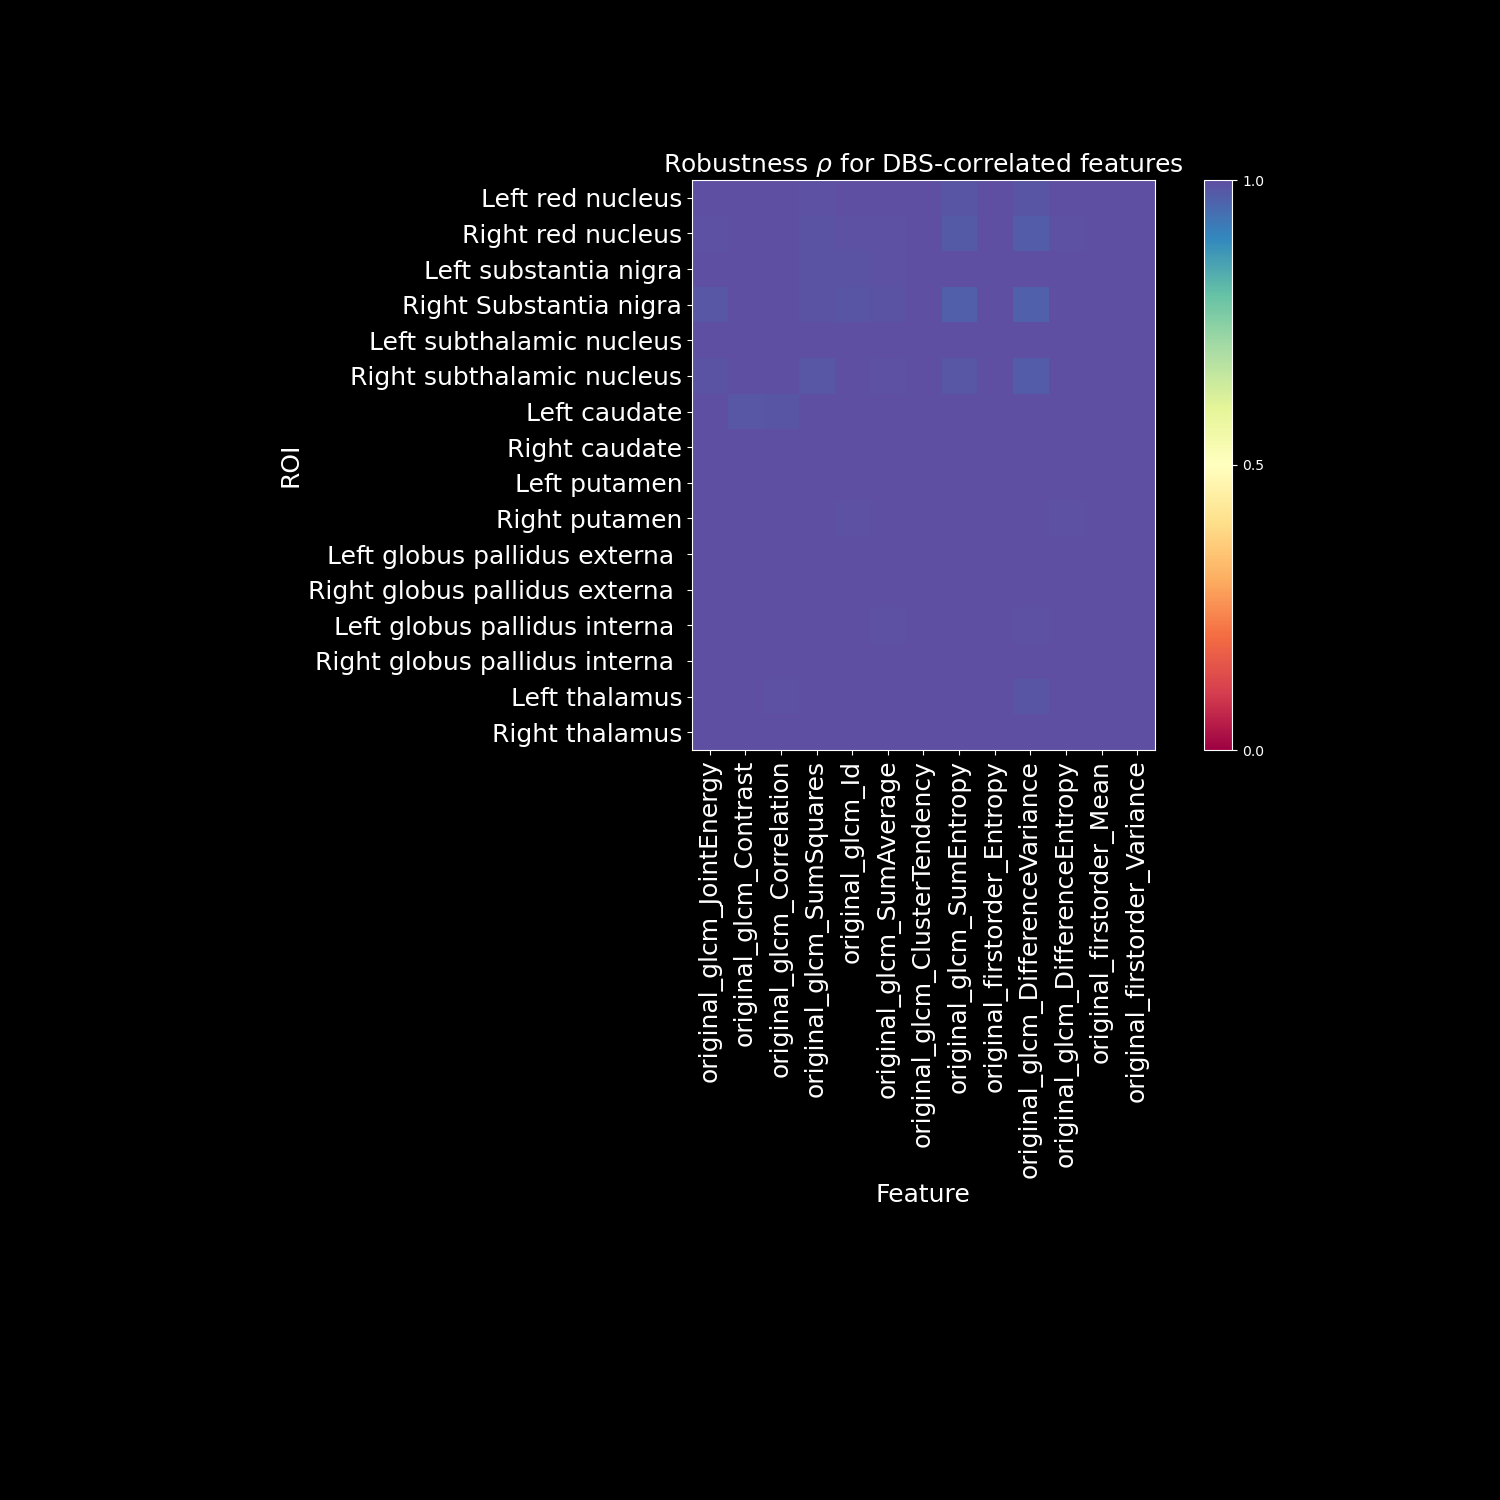

In [54]:
plt.close('all') 
fig, ax = plt.subplots(figsize = (15,15))
cax_im = ax.imshow(np.squeeze(rho_lrs[zfeats_idx,:].T),cmap='Spectral',vmin=0,vmax=1)
ax.set_ylabel('ROI',fontsize=18)
ax.set_xlabel('Feature',fontsize=18)
plt.yticks(np.arange(len(R[0:16])))
plt.xticks(np.arange(len(zfeats_idx)))
ax.set_yticklabels(R_rs[0][0].tolist(),rotation='horizontal',fontsize=18)
ax.set_xticklabels(Kc_lrs[zfeats_idx,4].tolist(),rotation='vertical',fontsize=18)
plt.colorbar(cax_im,cmap='Spectral',ticks=(0,0.5,1))
plt.title(r'Robustness $\rho$ for DBS-correlated features',fontsize=18)
fig.subplots_adjust(bottom=0.5)
fig.subplots_adjust(left=0.25)
plt.show()

In [26]:
rf_lrs = rho_lrs > 0.85
np.sum([Mc_lrs.ravel() > 0.85])/len(Mc_lrs.ravel())
np.sum([Mi_lrs.ravel() > 0.85])/len(Mi_lrs.ravel())
np.sum([(Mi_lrs.ravel() > 0.75) & (Mc_lrs.ravel() > 0.75)])/len(Mi_lrs.ravel())
np.sum([(Mi_vds.ravel() > 0.75) & (Mc_vds.ravel() > 0.75)])/len(Mi_vds.ravel())
np.sum([rhoc_vds.ravel() > 0.85])/len(rho_vds.ravel())
np.sum([Mc_vds.ravel() > 0.85])/len(Mc_vds.ravel())
np.sum([Mi_vds.ravel() > 0.85])/len(Mi_vds.ravel())
res = wilcoxon(rhoc_vds.ravel(),rhoc_lrs.ravel())
res.statistic, res.pvalue

(31741866.0, 0.0)

In [27]:
im_type = np.empty((Mc_lrs.shape[0],Mc_lrs.shape[1]),dtype=object)
feat_class = np.empty((Mc_lrs.shape[0],Mc_lrs.shape[1]),dtype=object)
Kcs = np.empty((Mc_lrs.shape[0],Mc_lrs.shape[1]),dtype=object)

lbp_count = 0
log_count = 0
orig_count = 0
square_count = 0
squareroot_count = 0
wavelet_count = 0
exp_count = 0
grad_count = 0

exp_idx = []
lbp_idx = []
log_idx = []
orig_idx = []
square_idx = []
squareroot_idx = []
wavelet_idx = []
grad_idx = []

for i in np.arange(Mc_lrs.shape[0]):
    for j in np.arange(1):
        feat_class[i,j] = Kc[i,j].rsplit('_',2)[1]
        im_type[i,j] = Kc[i,j].rsplit('_',2)[0]
        Kcs[i,j] = Kc[i,j].rsplit('_',1)[1]
        if im_type[i,j] == 'exponential':
            exp_count = exp_count+1
            exp_idx.append(i)
        if im_type[i,j] == 'gradient':
            grad_count = grad_count+1
            grad_idx.append(i)
        if im_type[i,j] == 'lbp-3D-k':
            lbp_count = lbp_count+1
            lbp_idx.append(i)
        if im_type[i,j] == 'logarithm':
            log_count = log_count+1
            log_idx.append(i)
        if im_type[i,j] == 'original':
            orig_count = orig_count+1
            orig_idx.append(i)
        if im_type[i,j] == 'square':
            square_count = square_count+1
            square_idx.append(i)
        if im_type[i,j] == 'squareroot':
            squareroot_count = squareroot_count+1
            squareroot_idx.append(i)
        if 'wavelet' in im_type[i,j]:
            wavelet_count = wavelet_count+1
            wavelet_idx.append(i)


In [28]:
def imfeat_plotter(lower_idx,upper_idx,title_string):
    plt.close('all') 
    fig, ax = plt.subplots(figsize = (15,10))
    if title_string == 'wavelet':
        L = (upper_idx-lower_idx)
        print(L)
        cax = ax.imshow(((Mc_lrs[lower_idx:upper_idx]*Mi_lrs[lower_idx:upper_idx,:]).T).reshape((6,L/6)), interpolation='nearest', 
            cmap='Spectral', vmin=0, vmax=1)
    else:
        cax = ax.imshow((Mc_lrs[lower_idx:upper_idx]*Mi_lrs[lower_idx:upper_idx,:]).T, interpolation='nearest', 
                    cmap='Spectral', vmin=0, vmax=1)
    ax.set_xlabel('Feature index')
    ax.set_ylabel('ROI index')
    plt.xticks(np.arange(upper_idx-lower_idx))
    plt.yticks(np.arange(Mc_vds.shape[1]))
    ax.set_xticklabels(Kcs[lower_idx:upper_idx,0], rotation='vertical', fontsize=7)
    ax.set_yticklabels(R_rs[0][0],rotation='horizontal',fontsize=7)
    plt.title('Robustness $\\rho$ between ground truth and LARO for '+title_string+' image')
    divider = make_axes_locatable(ax)
    caxf = divider.append_axes('right', size='5%', pad=0.05)
    plt.colorbar(cax, cax=caxf, orientation='vertical',ticks=[0, 0.5, 1])
    plt.show()

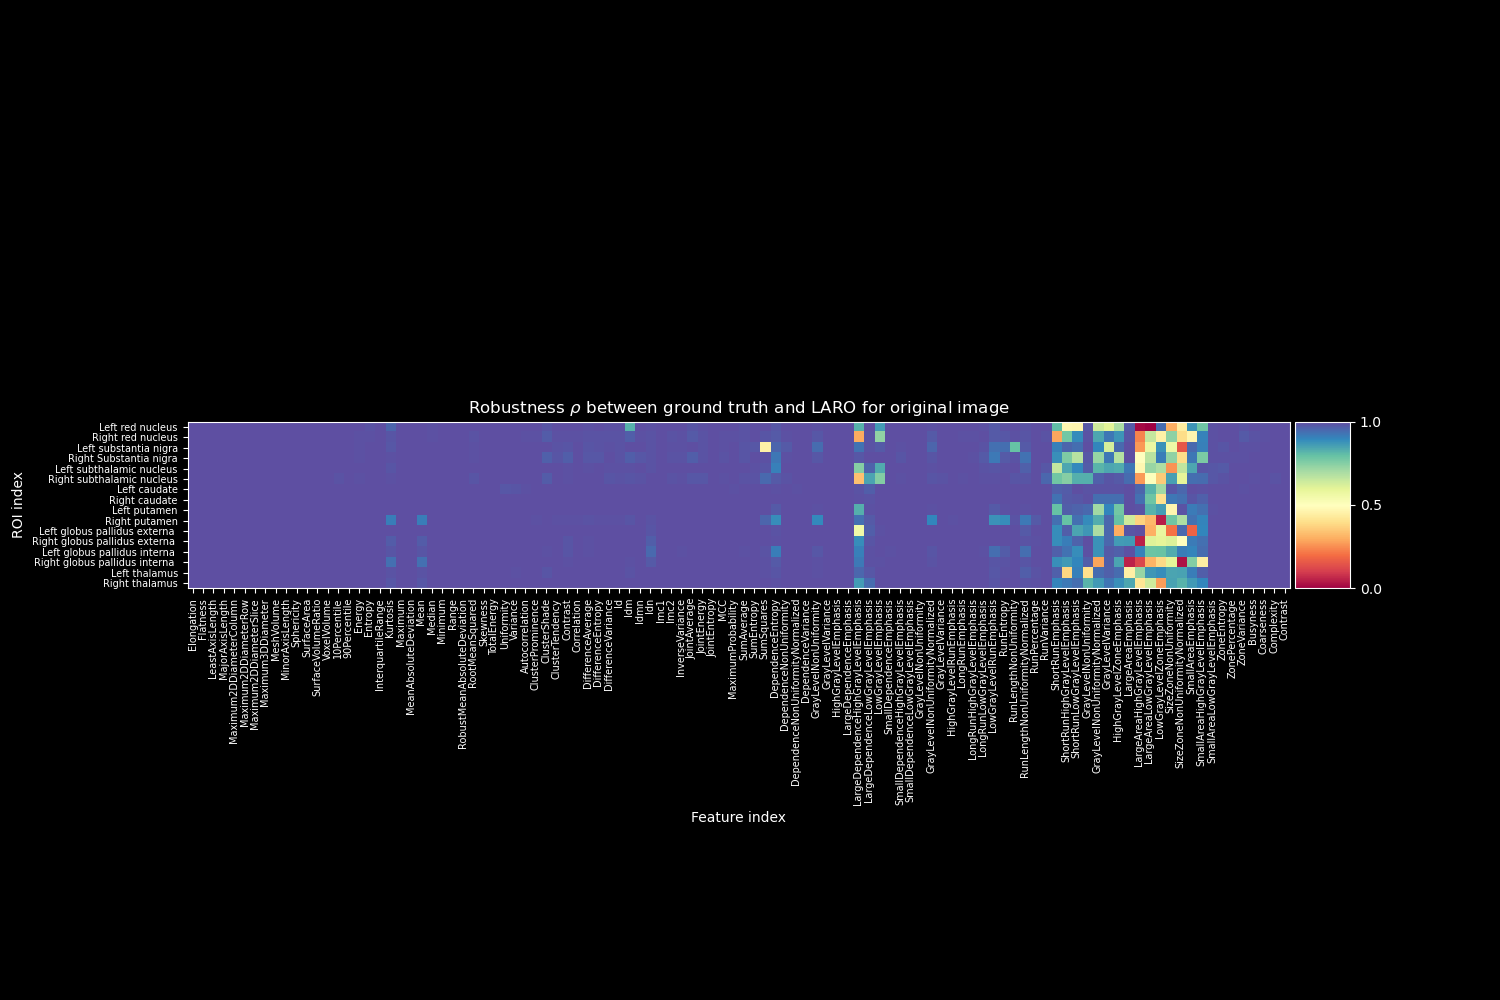

In [39]:
imfeat_plotter(np.min(orig_idx),np.max(orig_idx),'original')

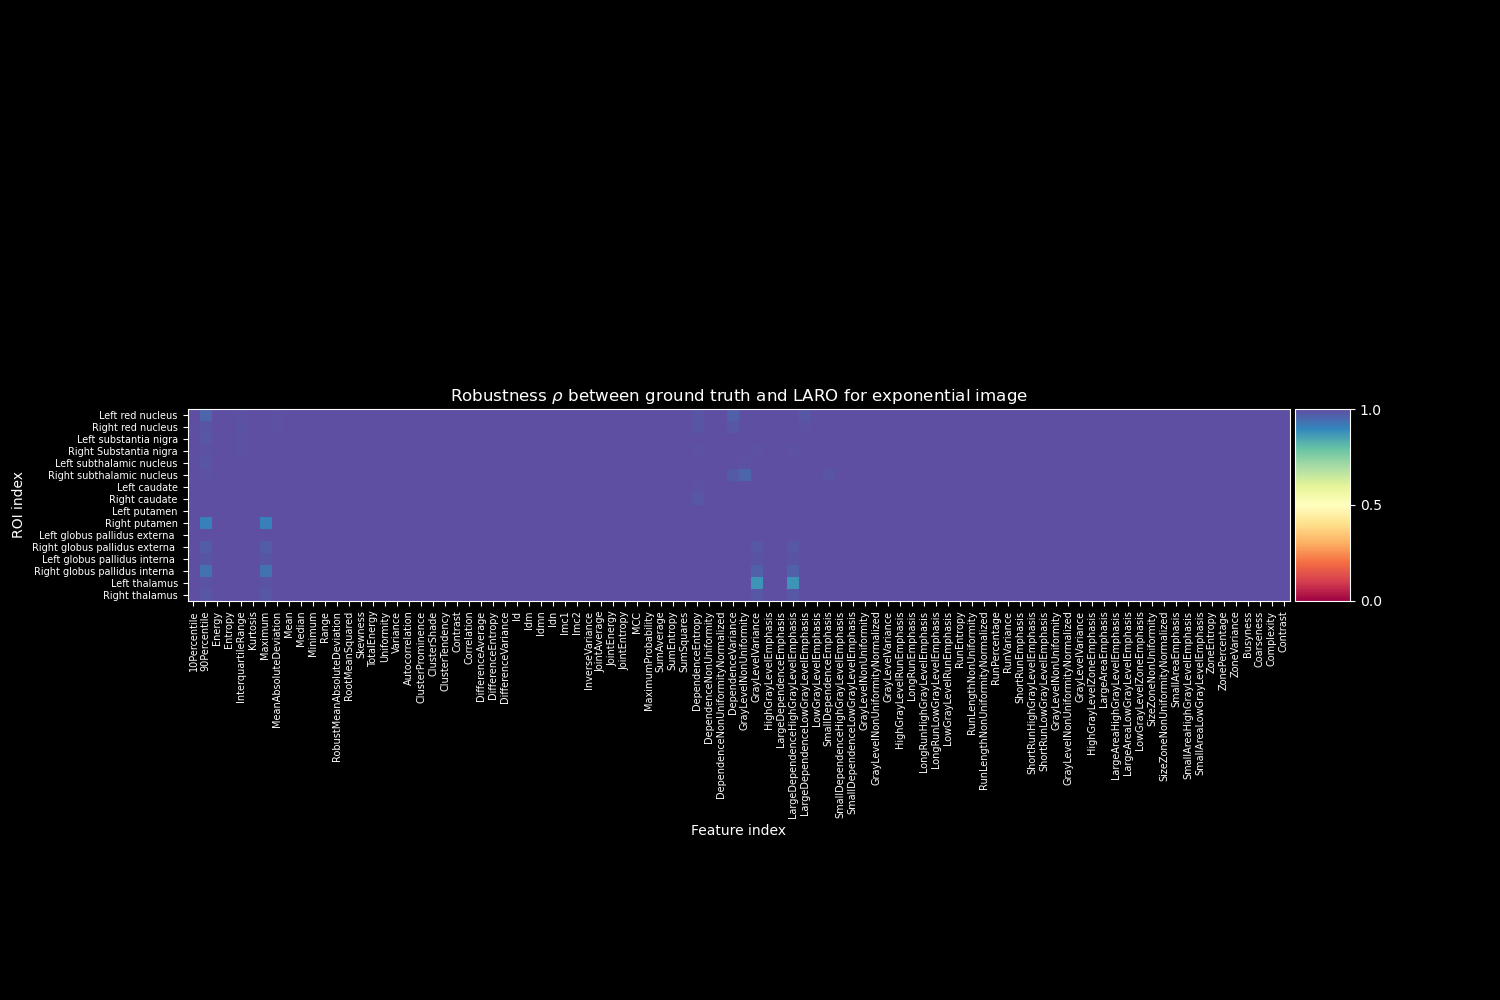

In [40]:
imfeat_plotter(np.min(exp_idx),np.max(exp_idx),'exponential')

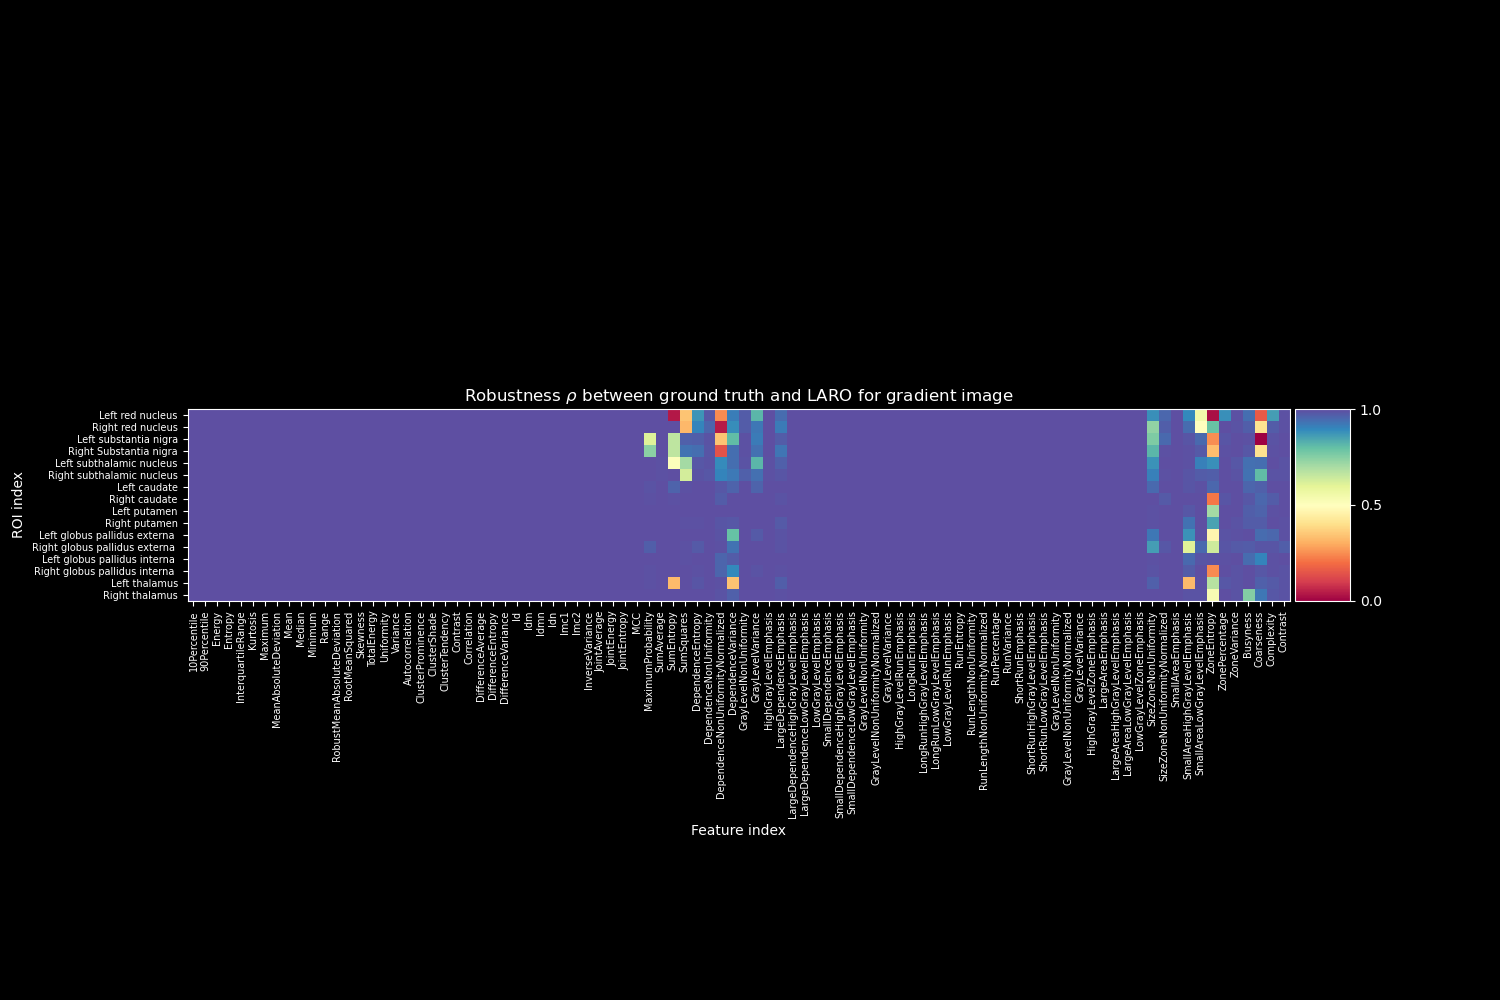

In [41]:
imfeat_plotter(np.min(grad_idx),np.max(grad_idx),'gradient')

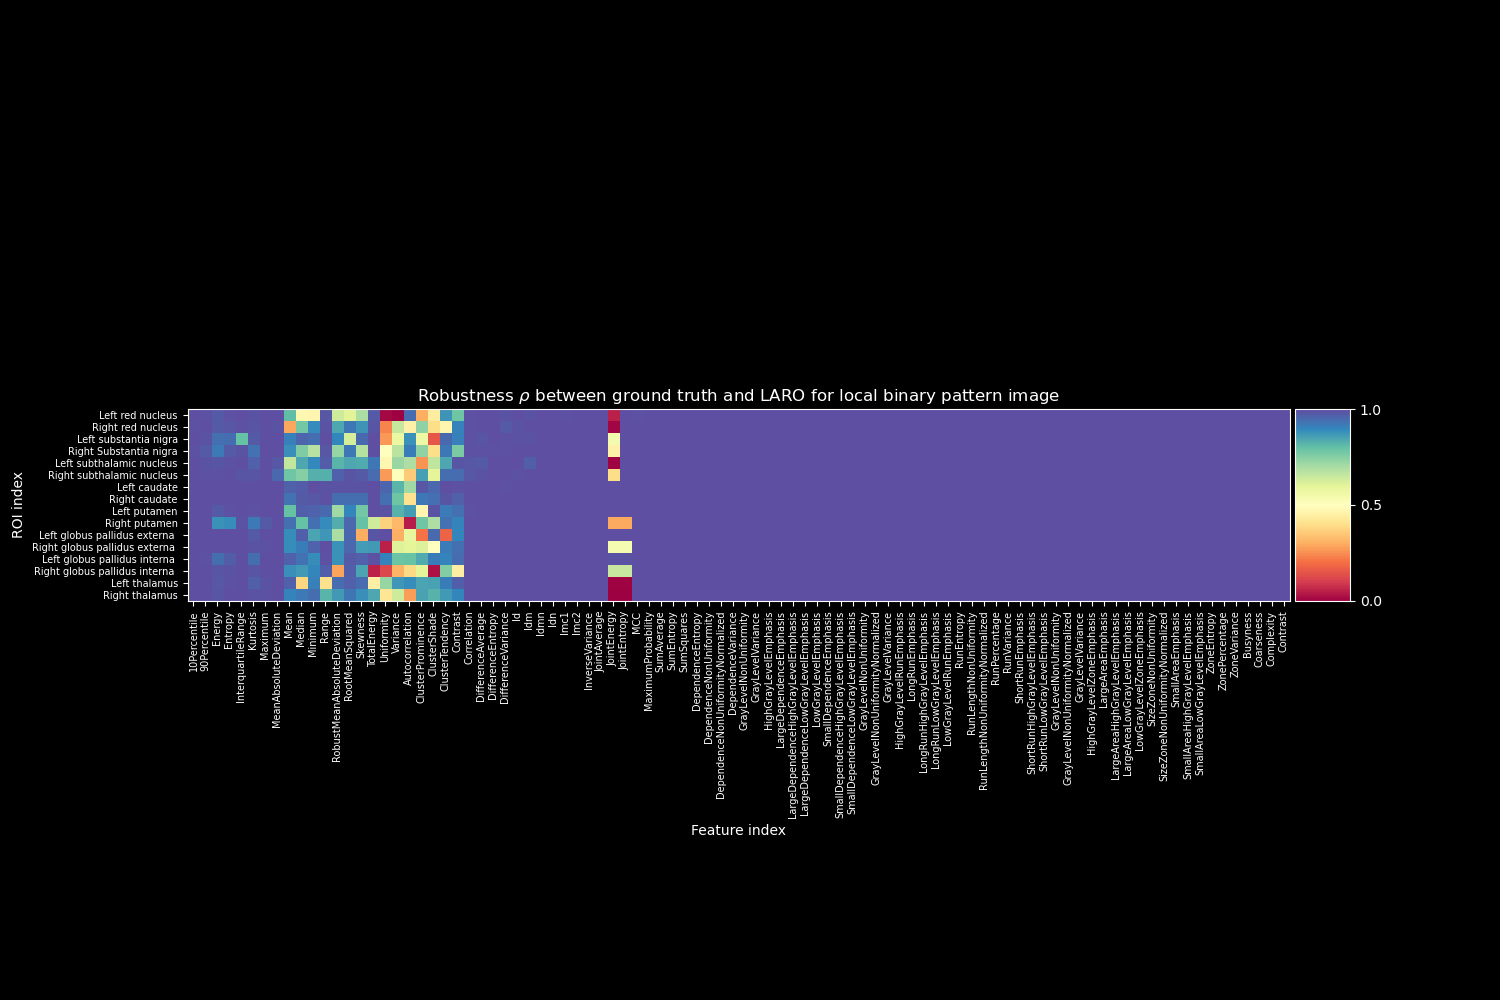

In [42]:
imfeat_plotter(np.min(lbp_idx),np.max(lbp_idx),'local binary pattern')

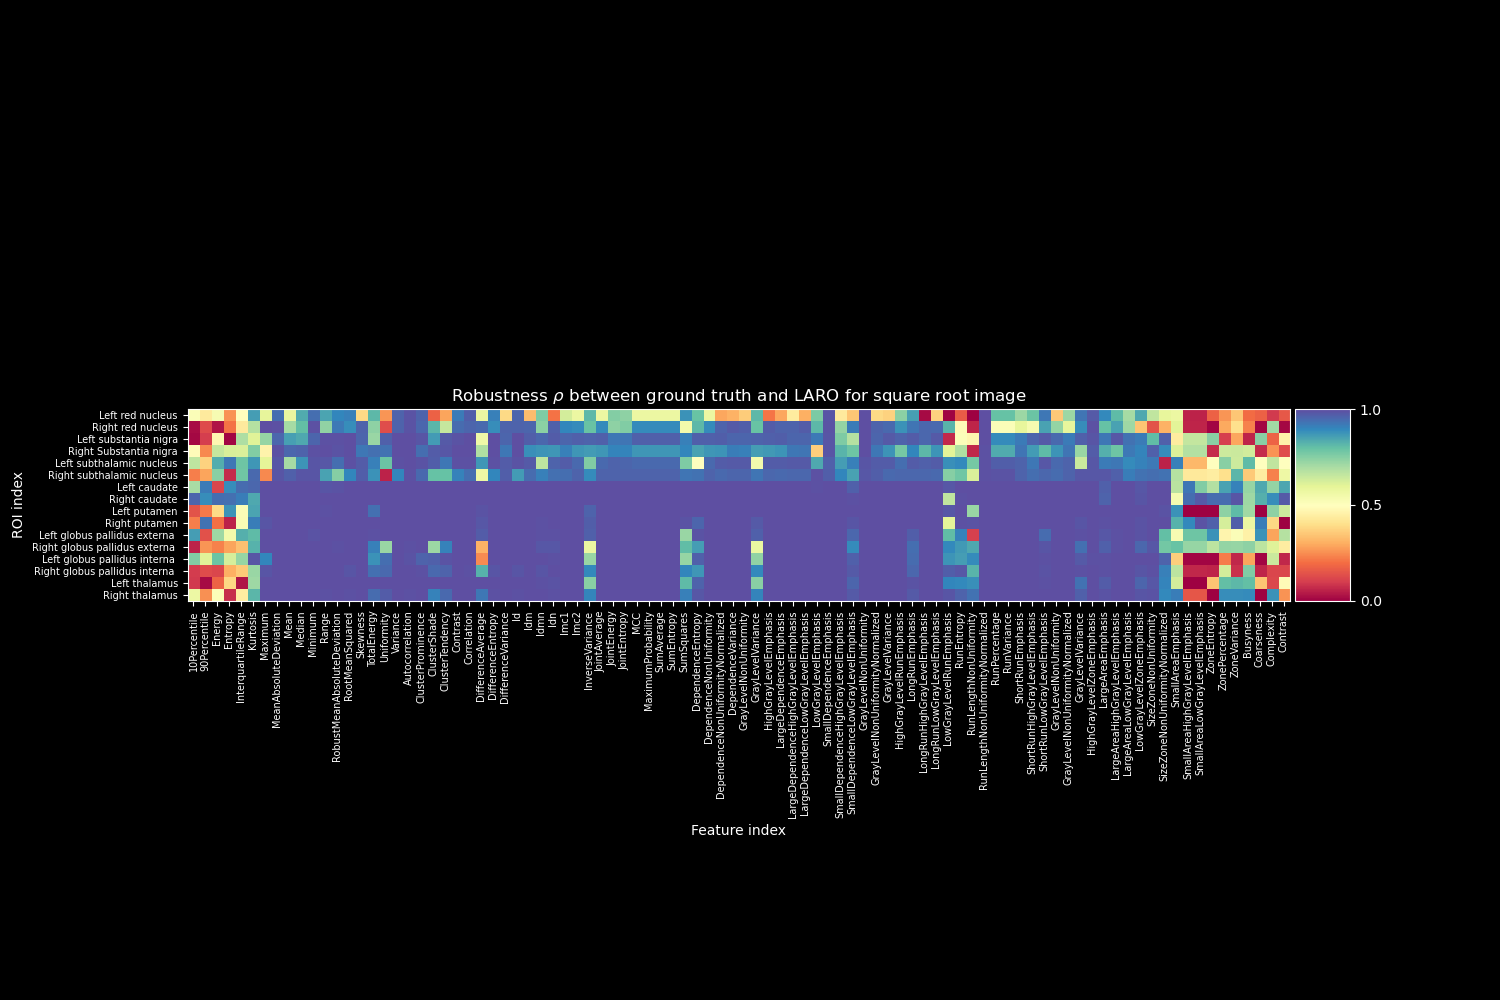

In [43]:
imfeat_plotter(np.min(squareroot_idx),np.max(squareroot_idx),'square root')

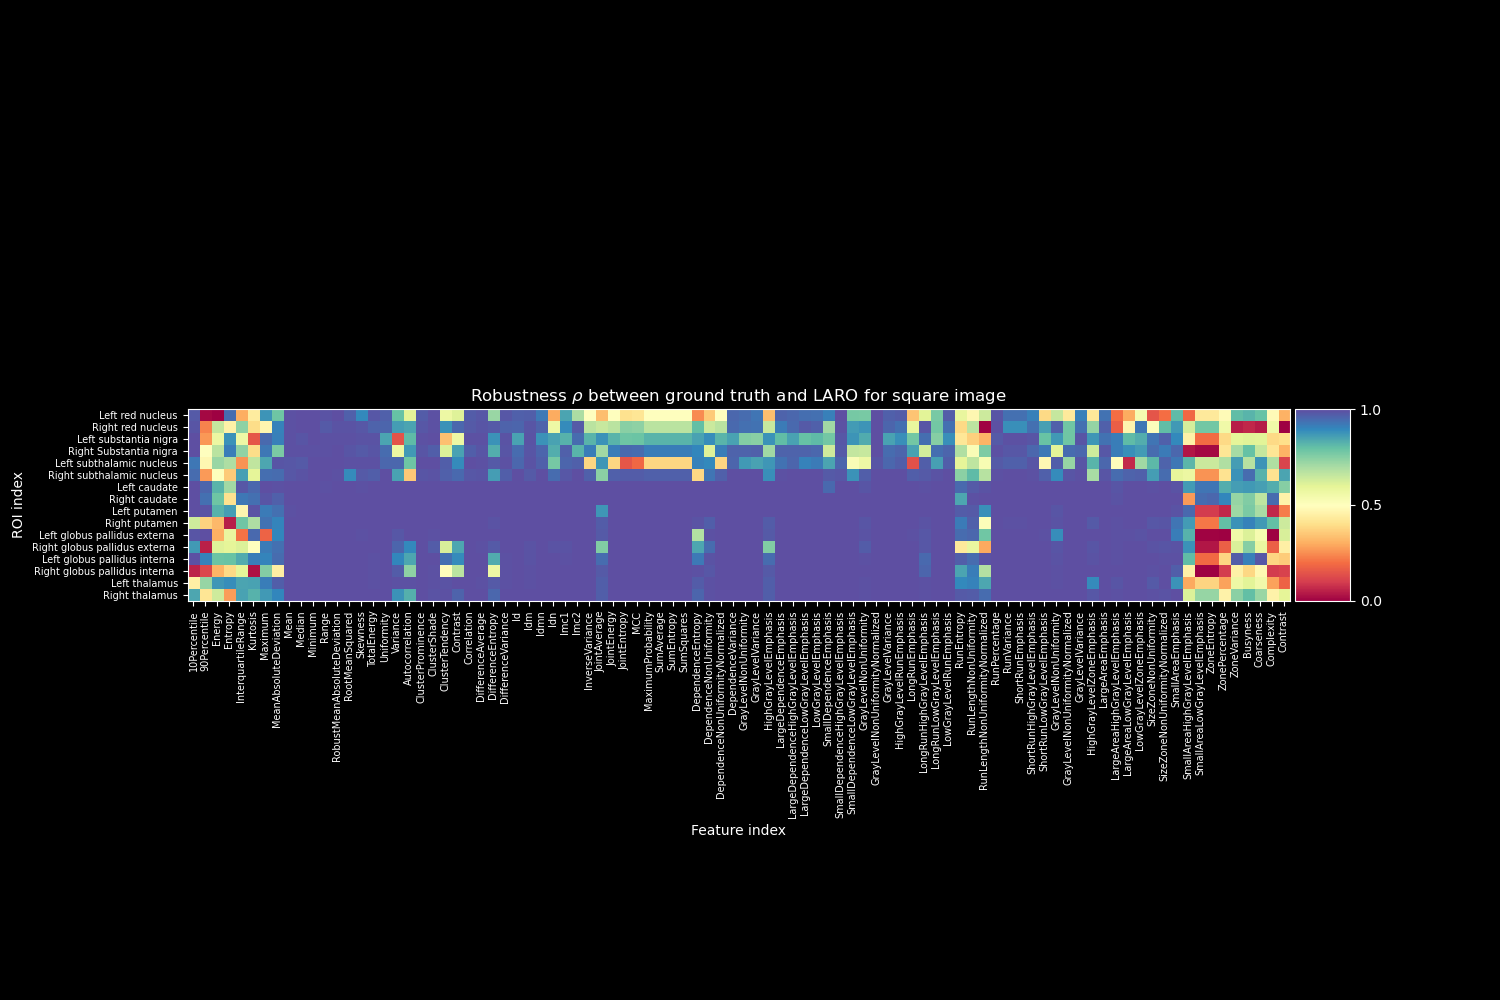

In [44]:
imfeat_plotter(np.min(square_idx),np.max(square_idx),'square')

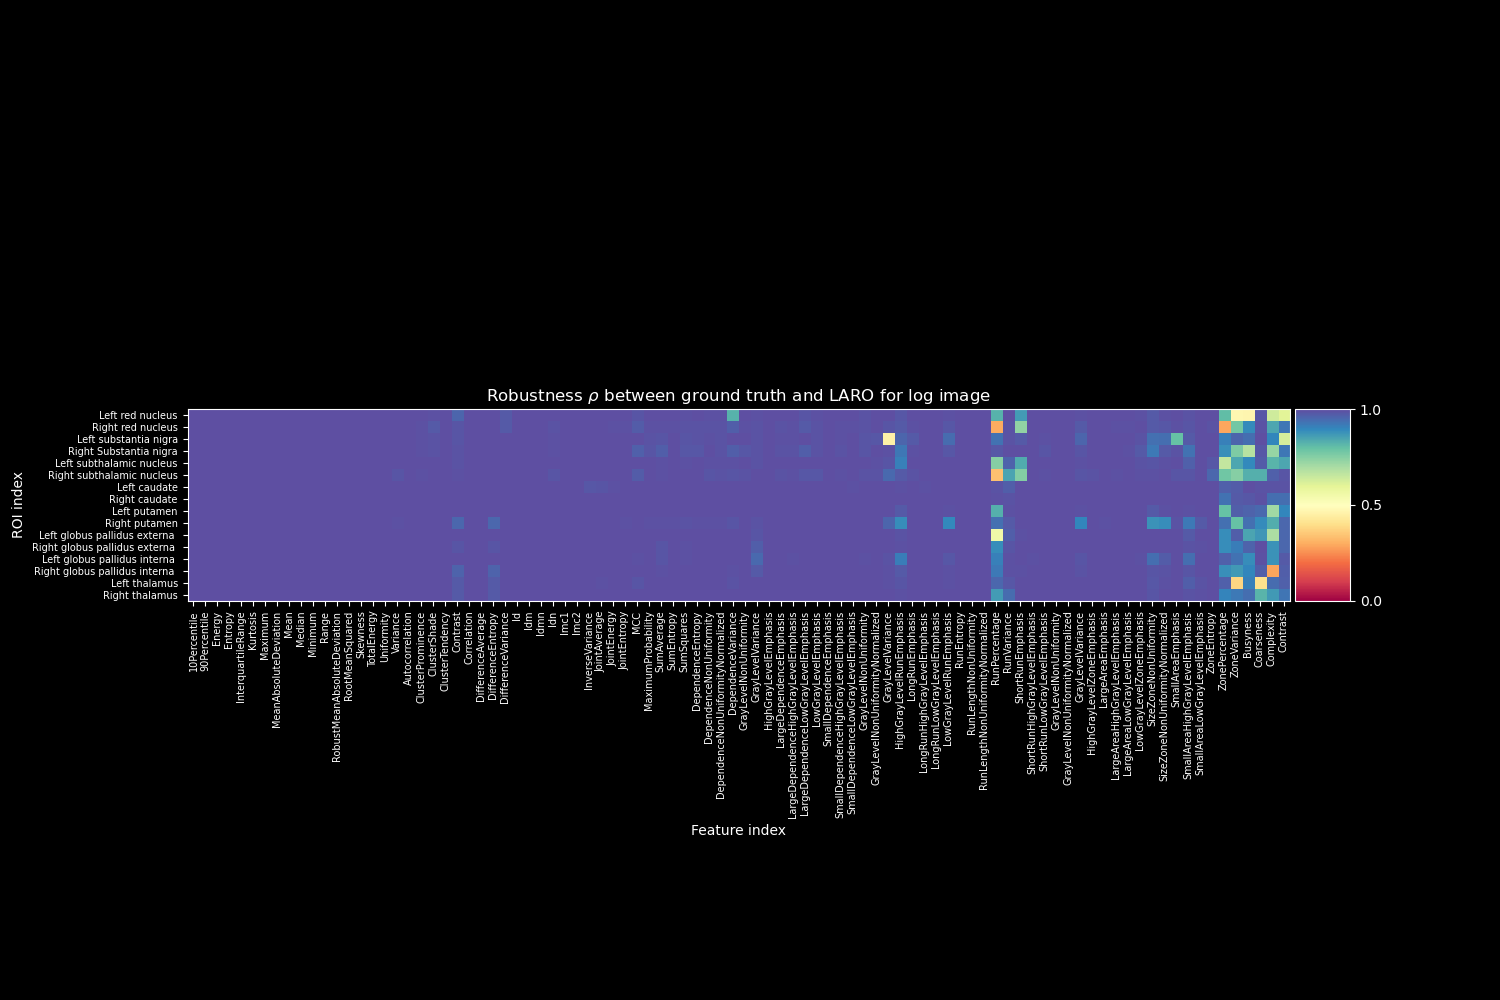

In [45]:
imfeat_plotter(np.min(log_idx),np.max(log_idx),'log')

In [59]:
np.amin(Mc_lrs)

-0.9021081846476605

In [65]:
R_rs[0][0]

array(['Left red nucleus', 'Right red nucleus', 'Left substantia nigra',
       'Right Substantia nigra', 'Left subthalamic nucleus',
       'Right subthalamic nucleus', 'Left caudate', 'Right caudate',
       'Left putamen', 'Right putamen', 'Left globus pallidus externa ',
       'Right globus pallidus externa ', 'Left globus pallidus interna ',
       'Right globus pallidus interna ', 'Left thalamus',
       'Right thalamus'], dtype='<U30')

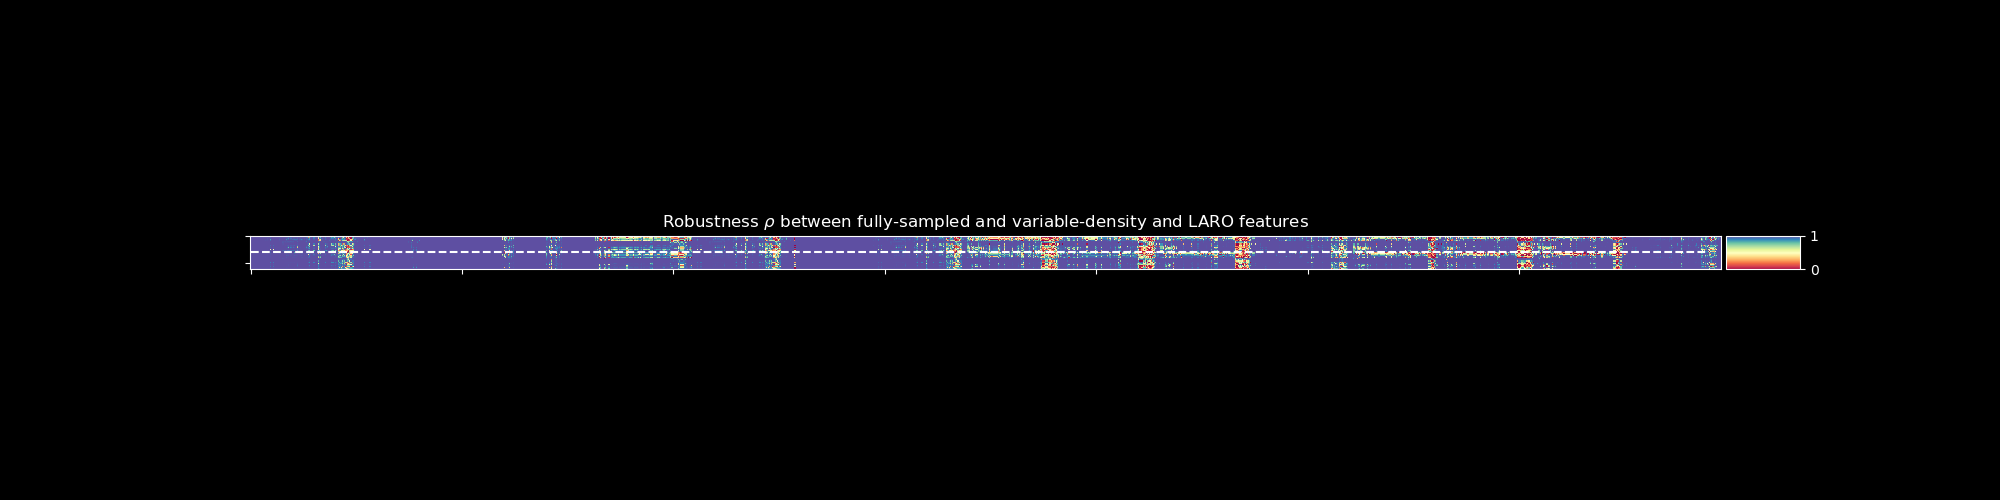

Unhandled message type set_device_pixel_ratio. {'device_pixel_ratio': 1.0972222089767456, 'type': 'set_device_pixel_ratio'}


In [96]:
# def plot_all_features():
plt.close('all') 
fig, ax = plt.subplots(figsize = (20,5))
im = ax.imshow(np.vstack(((Mc_vds*Mi_vds).T,(Mc_lrs*Mi_lrs).T)),interpolation='nearest',cmap='Spectral',vmin=0,vmax=1)
ax.hlines(n_rois-0.5,0,((Mc_vds*Mi_vds).shape[0]-(n_rois-0.5)),linestyle='dashed',color='white')
# ax.set_xlabel('Feature index')
# ax.set_ylabel('ROI index')
# plt.xticks(np.arange(rhoc_lrs.shape[0]))
# plt.yticks(np.arange(2*Mc_vds.shape[1]))
ax.set_xticklabels([])
ax.set_yticklabels([])
# ax.set_xticklabels(Kc_vds[:rhoc_lrs.shape[0],1], rotation='vertical', fontsize=7)
# ax.set_yticklabels(np.matlib.repmat(R_rs[0][0],2,1).ravel(),rotation='horizontal',fontsize=7)
plt.title('Robustness $\\rho$ between fully-sampled and variable-density and LARO features')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im, cax=cax, orientation='vertical')
plt.show()


In [37]:
def filter_keys(d, keys):
    return {k: v for k, v in d.items() if keys not in k}

In [38]:
def find_keys(d, keys):
    return {k: v for k, v in d.items() if keys in k}